# Лабораторная работа №4

## 4.1. Случайные ошибки как квантовый процесс

In [1]:
import numpy as np
from scipy.stats import bernoulli

Сгенерируем случайное чистое состояние $|\psi \rangle$ размерности $d$.

In [2]:
d = 4
phys_ind = [d]
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi = state / np.sqrt(np.sum(state * np.conjugate(state)))

Функция для генерации унитарного оператора $\hat{U}_e$.

In [3]:
def get_ue(e):
    return np.diag(np.array([1, np.exp(1j * e * np.pi / 3), 1, np.exp(1j * e * np.pi / 9)], dtype=complex))

Функция для генерации случайного параметра $e$.

In [4]:
def get_e(a, b):
    return a + (b - a) * np.random.rand()

Выполняем $n$ численных экспериментов. В каждом эксперименте вычисляем $|\varphi \rangle = \hat{U}_e |\psi \rangle$. Расчитываем вероятность $p = |\langle 0 | \varphi \rangle|^2$ и используем её для генерации результата испытания Бернулли ($0$ или $1$).
Вычисляем общее число $k$ результатов $1$. Оценим вероятность по результатам измерений как $\hat{p} = \dfrac{k}{n}$.

In [5]:
def get_p_mean(psi, n, gamma):
    k = 0
    for i in range(n):
        e = get_e(-gamma, gamma)
        ue = get_ue(e)
        phi = np.dot(ue, psi)
        p = np.abs(phi[0]) ** 2
        result = bernoulli.rvs(p)
        if result == 1:
            k += 1
    p_mean = k / n
    return p_mean

In [6]:
n = 1000
gamma = 1.5

In [7]:
print(get_p_mean(psi, n, gamma))

0.251


Выполним описанную в предыдущем пункте процедуру $1000$ раз.

In [8]:
m = 1000

In [9]:
list_p_mean = []
for i in range(m):
    list_p_mean.append(get_p_mean(psi, n, gamma))

In [10]:
list_p_mean_exact = []
for i in range(m):
    list_p_mean_exact.append(get_p_mean(psi, n, 0.0))

In [11]:
import matplotlib.pyplot as plt

Построим гистограмму распределения $\hat{p}$.

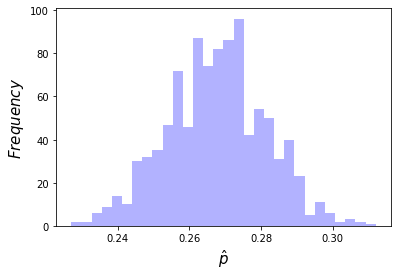

In [12]:
plt.hist(list_p_mean, bins=30, color='blue', alpha=0.3)
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

Построим также гистограмму для случая $e = 0$.

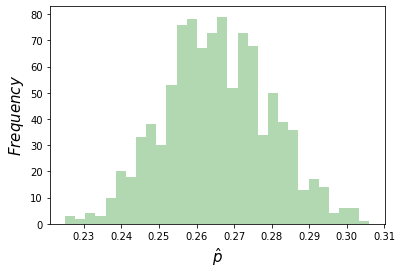

In [13]:
plt.hist(list_p_mean_exact, bins=30, color='green', alpha=0.3)
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

Напишем функцию для вытягивания матрицы в столбец.

In [14]:
def col(matrix, d):
    return np.reshape(matrix, -1, order='F').reshape((d ** 2, 1))

И функцию, которая столбец превращает в матрицу.

In [15]:
def col_reverse(column, d):
    return np.reshape(column, (d, d), order='F')

Для дальнейшего усреднения (интегрирования по функции плотности вероятности), напишем функцию, которая будет генерировать матрицу $\chi_U$ по параметру $e$ по формуле $\chi_U = e_U e_U^{\dagger}$, где $e_U = \begin{pmatrix} U[:, 0] \\ U[:, 1] \\  \vdots \\ U[:, d] \end{pmatrix}$.

In [16]:
def get_chi(e):
    e_u = col(get_ue(e), d)
    chi_u = np.dot(e_u, e_u.T.conjugate())
    return chi_u

Для численного интегрирования рассмотрим следующие сегменты для параметра $e$.

In [17]:
number_of_steps = 100000
e_span = np.linspace(-gamma, gamma, number_of_steps)

Напишем функцию, которая будет выдавать функцию плотности вероятности.

In [18]:
def get_func_dist(x, gamma):
    f = 0.0
    if x < -gamma:
        f = 0.0
    elif x > gamma:
        f = 0.0
    else:
        f = 1 / (2 * gamma)
    return f

Для расчёта матрицы $\chi$ произведём усреднение матриц $\chi_U$ по параметру $e$ по формуле $\chi = \int \chi_{U(e)} p(e) de$.

In [19]:
chi = np.zeros((d ** 2, d ** 2), dtype=complex)

In [20]:
delta_e = 2 * gamma / number_of_steps
for e in e_span:
    chi += get_func_dist(e, gamma) * get_chi(e) * delta_e

Так как $\chi = \sum_k \operatorname{Col} (E_k) {\operatorname{Col} (E_k)}^{\dagger}$, то нам нужно найти разложение $\chi = e e^{\dagger}$, где $e = (E_1, \dots, E_{d^2})$. Чтобы найти такое разложение, нам нужно сделать спектральное разложение матрицы $\chi = U D U^{\dagger}$, тогда $e = U \sqrt{D}$.

In [21]:
D, U = np.linalg.eig(chi)

In [22]:
e = U @ np.sqrt(np.diag(D))

Теперь находим $d^2$ матриц Крауса по формуле $E_k = \operatorname{Col}^{-1}(e[:, k])$.

In [23]:
list_kraus = []
d ** 2
for i in range(d ** 2):
    list_kraus.append(col_reverse(e[:, i].reshape(d ** 2, 1), d))

Проверим, что $\sum_k E_k^{\dagger} E_k = I$.

In [24]:
sum_of_kraus = np.zeros((d, d), dtype=complex)
for kraus in list_kraus:
    sum_of_kraus += kraus.T.conjugate() @ kraus
print(sum_of_kraus)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


Вычислим матрицу плотности $\rho$ на выходе полученного процесса по формуле $\rho = \sum_k E_k \rho_0 E_k^{\dagger}$, где $\rho_0 = |\psi\rangle \langle \psi|$.

In [25]:
rho_0 = np.dot(psi.T.conjugate().reshape(d, 1), psi.reshape(1, d))
rho = np.zeros((d, d), dtype=complex)
for kraus in list_kraus:
    rho += kraus @ rho_0 @ kraus.T.conjugate()
print(rho)

[[ 0.26656259+7.73381243e-34j  0.14799165+6.77273786e-02j
  -0.05445365+2.40598785e-01j -0.10499464+2.28397355e-01j]
 [ 0.14799165-6.77273786e-02j  0.24519243-3.85185989e-34j
   0.03089871+1.47412341e-01j -0.00035507+2.08787332e-01j]
 [-0.05445365-2.40598785e-01j  0.03089871-1.47412341e-01j
   0.22828776+3.85185989e-34j  0.22759934+4.81107068e-02j]
 [-0.10499464-2.28397355e-01j -0.00035507-2.08787332e-01j
   0.22759934-4.81107068e-02j  0.25995723+4.70197740e-38j]]


Вычислим вероятность $p_{\mathcal{E}} = \langle 0|\rho|0 \rangle$.

In [26]:
p_E = rho[0, 0].real
print(p_E)

0.2665625864456716


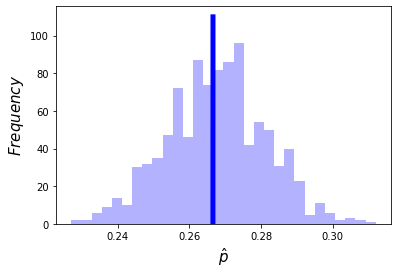

In [27]:
plt.hist(list_p_mean, bins=30, color='blue', alpha=0.3)
plt.plot(np.array([p_E - 0.00001, p_E + 0.00001]), np.array([0.0, 110.0]), lw=5, color='blue')
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

Видно, что полученная аналитическая вероятность примерно равна среднему от распределения вероятностей $\hat{p}$.

## 4.2. Зашумлённые квантовые схемы

Реализуем класс $\operatorname{State()}$, с помощью которого будем симулировать гейтовую схему.

In [28]:
class State(object):
    def __init__(self):
        self.N = None
        self.len = None
        self.phys_ind = []
        self.full_vector = None

    def all_zeros_state(self, n):
        self.N = n
        self.len = 2 ** self.N
        self.phys_ind = []
        self.full_vector = np.zeros(2 ** self.N, dtype=complex)
        self.full_vector[0] = 1.0
        for i in range(n):
            self.phys_ind.append(2)

    def return_full_vector(self):
        return self.full_vector

    def one_qubit_gate(self, u, k):
        state_tensor = self.full_vector.reshape(self.phys_ind)
        state_tensor = np.transpose(state_tensor, axes=tuple([k] + list(np.arange(0, k, 1)) +
                                                             list(np.arange(k + 1, self.N, 1))))
        state_matrix = state_tensor.reshape(2, 2 ** (self.N - 1))
        new_state_matrix = np.dot(u, state_matrix)
        new_state_tensor = new_state_matrix.reshape(self.phys_ind)
        new_state_tensor = np.transpose(new_state_tensor, axes=tuple(list(np.arange(1, k + 1, 1)) + [0] +
                                                                     list(np.arange(k + 1, self.N, 1))))
        self.full_vector = new_state_tensor.reshape(-1)

    def two_qubit_gate(self, u, k, l):
        state_tensor = self.full_vector.reshape(self.phys_ind)
        state_tensor = np.transpose(state_tensor, axes=tuple([k, l] + list(np.arange(0, k, 1)) +
                                                             list(np.arange(k + 1, l, 1)) +
                                                             list(np.arange(l + 1, self.N, 1))))
        state_matrix = state_tensor.reshape(4, 2 ** (self.N - 2))
        new_state_matrix = np.dot(u, state_matrix)
        new_state_tensor = new_state_matrix.reshape(self.phys_ind)
        new_state_tensor = np.transpose(new_state_tensor, axes=tuple(list(np.arange(2, k + 2, 1)) + [0] +
                                                                     list(np.arange(k + 2, l + 1, 1)) + [1] +
                                                                     list(np.arange(l + 1, self.N, 1))))
        self.full_vector = new_state_tensor.reshape(-1)

Определим гейты, которые будем использовать для реализации QFT.

In [29]:
def H():
    return (1 / np.sqrt(2)) * np.array([[1, 1],
                                        [1, -1]], dtype=complex)

In [30]:
def R_K_C(k):
    return np.array([[1, 0, 0, 0], 
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, np.exp(2 * np.pi * 1j / (2 ** k))]], dtype=complex)

In [31]:
def R(delta, theta, phi):
    r_11 = np.cos(delta / 2) - 1j * np.cos(theta) * np.sin(delta / 2)
    r_12 = -1j * np.sin(theta) * np.sin(delta / 2) * np.exp(-1j * phi)
    r_21 = -1j * np.sin(theta) * np.sin(delta / 2) * np.exp(1j * phi)
    r_22 = np.cos(delta / 2) + 1j * np.cos(theta) * np.sin(delta / 2)
    return np.array([[r_11, r_12],
                     [r_21, r_22]], dtype=complex)

Напишем функцию, которая будет определять последовательность гейтов для QFT.

In [32]:
def QFT(state, n, gamma):
    for i in range(0, n - 1, 1):
        state.one_qubit_gate(H(), i)
        e = get_e(-gamma, gamma)
        state.one_qubit_gate(R(np.pi * e / 20, np.pi / 2 + e, 0), i)
        for j in range(2, n - i + 1, 1):
            state.two_qubit_gate(R_K_C(j), i, i + j - 1)
    state.one_qubit_gate(H(), n - 1)
    e = get_e(-gamma, gamma)
    state.one_qubit_gate(R(np.pi * e / 20, np.pi / 2 + e, 0), i)

In [33]:
n = 5
d = 2 ** n

Сгенерируем случайное чистое состояние $|\psi\rangle$ размерности $2^n$.

In [34]:
phys_ind = [d]
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi = state / np.sqrt(np.sum(state * np.conjugate(state)))
state = State()
state.all_zeros_state(n)
state.full_vector = psi

In [35]:
list_gamma = [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
k = 1000

In [36]:
def fidelity(phi, psi):
    return np.abs(np.dot(phi.T.conjugate(), psi)) ** 2

In [37]:
import copy

In [38]:
list_fidelity = []
state_new_exact = copy.deepcopy(state)
QFT(state_new_exact, n, 0.0)
for gamma in list_gamma:
    list_fidelity_gamma = []
    for i in range(k):
        state_new = copy.deepcopy(state)
        QFT(state_new, n, gamma)
        list_fidelity_gamma.append(fidelity(state_new_exact.full_vector, state_new.full_vector))
    list_fidelity.append(list_fidelity_gamma)
list_fidelity = np.array(list_fidelity)

Определяем среднее фиделити и нижний и верхний квартили.

In [39]:
list_fidelity_mean = []
list_fidelity_low_quantile = []
list_fidelity_high_quantile = []
for fidelity_gamma in list_fidelity:
    list_fidelity_mean.append(np.mean(fidelity_gamma))
    list_fidelity_low_quantile.append(np.quantile(fidelity_gamma, 0.25))
    list_fidelity_high_quantile.append(np.quantile(fidelity_gamma, 0.75))
list_fidelity_mean = np.array(list_fidelity_mean)
list_fidelity_low_quantile = np.array(list_fidelity_low_quantile)
list_fidelity_high_quantile = np.array(list_fidelity_high_quantile)
list_gamma = np.array(list_gamma)

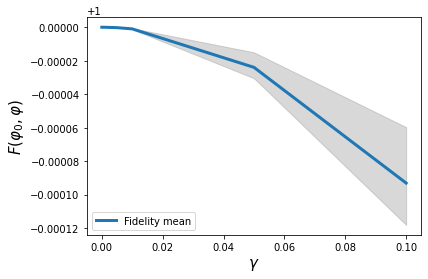

In [40]:
fig, ax = plt.subplots()
plt.plot(list_gamma, list_fidelity_mean, lw=3, alpha=1, label='Fidelity mean')
plt.fill_between(list_gamma, list_fidelity_low_quantile, list_fidelity_high_quantile, color='gray', alpha=0.3)
ax.legend(loc='lower left')
ax.minorticks_off()
plt.xlabel(r'$\gamma$', fontsize=15)
plt.ylabel(r'$F(\varphi_0, \varphi)$', fontsize=15)
plt.show()